In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
pd.options.display.max_columns=100

In [2]:
norm_loc = './cheese_5_selectors_4/'
files = os.listdir(norm_loc)

data = {'c01':[],'c02':[],'c03':[],'c04':[],'c05':[],'c06':[],'c07':[],'c08':[],'c09':[],'c10':[],'c11':[],'c12':[],'c13':[],
        'm01':[],'m02':[],'m03':[],'m04':[],'m05':[],'m06':[],'m07':[],'m08':[],'m09':[],'m10':[],'m11':[],'m12':[],'m13':[],
        'p01':[],'p02':[],'p03':[],'p04':[],'p05':[],'p06':[],'p07':[],'p08':[],'p09':[],'p10':[],'p11':[],'p12':[],'p13':[],
        'a01':[],'a02':[],'a03':[],'a04':[],'a05':[],'a06':[],'a07':[],'a08':[],'a09':[],'a10':[],'a11':[],'a12':[],'a13':[],'a14':[],'a15':[],
        'r01':[],'r02':[],'r03':[],'r04':[],'r05':[],'r06':[],'r07':[],'r08':[],'r09':[],'r10':[]}

mapper = {1:'S4', 2:'S4', 3:'S4', 4:'S4',
          5:'S5', 6:'S5', 7:'S5', 8:'S5', 
          9:'S6', 10:'S6', 11:'S6', 12:'S6',
          13:'S20', 14:'S20', 15:'S20', 16:'S20'}

for f in files:
    f = norm_loc + f
    if f[-12] == 'm':
        compound = 'm' + f[-7:-5]
    elif f[-15] == 'p':
        compound = 'p' + f[-7:-5]
    elif f[-16] == 'a':
        compound = 'a' + f[-7:-5]
    elif f[-19] == 'r':
        compound = 'r' + f[-7:-5]
    else:
        compound = 'c'+f[-7:-5]

    data_set = pd.read_excel(f, sheetname=None, header=None) # need to change sheetname to sheet_name for newer pd! ie if V runs
    for key in data_set.keys():
        data_set[key] = data_set[key].set_index(0)
        data_set[key] = data_set[key].rename(columns=mapper)
    data[compound].append(data_set['Sheet1']) # Currently working with just the first exposure
for comp in data:  
    data[comp] = pd.concat(data[comp], axis=1)

/home/ee/miniconda3/lib/python3.6/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


In [3]:
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.spatial.distance import pdist, squareform, euclidean
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

In [4]:
import itertools 
import warnings
import random
warnings.filterwarnings("ignore", category=DeprecationWarning)

def get_classifier(classifier):
    if classifier == 'LR':
        return LogisticRegressionCV(cv=3, penalty='l1', solver='saga', n_jobs=-1)
    elif classifier == 'RF':
        return RandomForestClassifier(n_estimators=100, n_jobs=-1)
    elif classifier == 'KNN':
        return KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
    elif classifier == 'SVM': # using the default RBF kernel..
        return SVC() 
    elif classifier == 'GP':
        kernel = 1.0 * RBF(1.0)
        return GaussianProcessClassifier(kernel=kernel, n_jobs=-1)
    else:
        print('You did not input a valid classifier, please use one of: KNN, LR or RF')
        return
    
def get_majority_vote(vote_count_dict):
    highest_count = 0
    key_highest = None
    shared_highest = []
    for k,v in vote_count_dict.items():
        if v > highest_count:
            highest_count = v
            key_highest = k
            shared_highest = [(k,v)]
        elif v == highest_count:
            shared_highest.append((k,v))
    if len(shared_highest) > 1:
        rand_int = random.randint(0,len(shared_highest)-1)
        key_highest = shared_highest[rand_int][0]
        # get random value in 0..len(shared_highest) and use this to set the key_highest
    return key_highest


def normalize_selector(sel_data):
    max_val = sel_data.max()
    min_val = sel_data.min()
    max_min = max_val - min_val
    sel_data = (sel_data - min_val) / float(max_min)
    return sel_data

In [6]:
#### issue different number of samples for each of the cheeses.....going to 10...
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
import itertools


# getting the data into a format for the extract_features....
start = 300
end = 600
length=end-start
selectors = [4,5,6,20]
combined = []
for select in selectors:
    selector = []
    for w in sorted(data.keys()):
        if w[0] in ['c', 'm', 'p']:
            if w[1:] in ['01', '02', '03']:
                continue
        elif int(w[1:]) > 10:
            continue
        selector_data = data[w]['S'+str(select)]
        selector_data = selector_data.T.fillna(selector_data.mean(axis=1)).T 
        selector.append(selector_data)
    selector = pd.concat(selector, axis=1)
    selector = selector.values.T
    selector = selector[:, start:end].reshape(-1,1)
    combined.append(selector)
combined = np.concatenate(combined, axis=1)
time = np.asarray([i for i in range(end-start)]*200).reshape(-1,1) # 4 (replicates in a TC) * 13 repeats *3 cheese = 36
combined = np.append(combined,time, axis=1)
combined_df = pd.DataFrame(combined, columns=['S4','S5', 'S6', 'S20', 'time'])
name_a = ['A1_{}'.format(i) for i in range(1,41)]
name_a = [[ele]*length for ele in name_a]
name_a = [j for i in name_a for j in i]
name_c = ['C1_{}'.format(i) for i in range(1,41)]
name_c = [[ele]*length for ele in name_c]
name_c = [j for i in name_c for j in i]
name_m = ['M1_{}'.format(i) for i in range(1,41)]
name_m = [[ele]*length for ele in name_m]
name_m = [j for i in name_m for j in i]
name_p = ['P1_{}'.format(i) for i in range(1,41)]
name_p = [[ele]*length for ele in name_p]
name_p = [j for i in name_p for j in i]
name_r = ['R1_{}'.format(i) for i in range(1,41)]
name_r = [[ele]*length for ele in name_r]
name_r = [j for i in name_r for j in i]
names = name_a + name_c + name_m + name_p + name_r
combined_df['id'] = names

extracted_feat = extract_features(combined_df, column_id="id", column_sort="time", column_kind=None, column_value=None)
impute(extracted_feat)

Feature Extraction: 100%|██████████| 20/20 [03:15<00:00,  5.64s/it]


variable,S20__abs_energy,S20__absolute_sum_of_changes,"S20__agg_autocorrelation__f_agg_""mean""","S20__agg_autocorrelation__f_agg_""median""","S20__agg_autocorrelation__f_agg_""var""","S20__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","S20__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","S20__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","S20__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","S20__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""","S20__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""rvalue""","S20__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""slope""","S20__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""stderr""","S20__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""intercept""","S20__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""rvalue""","S20__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""slope""","S20__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""stderr""","S20__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""intercept""","S20__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""rvalue""","S20__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""slope""","S20__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""stderr""","S20__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""intercept""","S20__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""rvalue""","S20__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""slope""","S20__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""stderr""","S20__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""intercept""","S20__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""rvalue""","S20__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""slope""","S20__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""stderr""","S20__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""intercept""","S20__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""rvalue""","S20__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""slope""","S20__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""stderr""","S20__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""intercept""","S20__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""rvalue""","S20__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""slope""","S20__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""stderr""","S20__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""intercept""","S20__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""rvalue""","S20__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""slope""","S20__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""stderr""","S20__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""intercept""","S20__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""rvalue""","S20__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""slope""","S20__agg_linear_trend__f_agg_""var""__chunk_len_10__attr_""stderr""","S20__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""intercept""","S20__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""rvalue""","S20__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""slope""","S20__agg_linear_trend__f_agg_""var""__chunk_len_50__attr_""stderr""","S20__agg_linear_trend__f_agg_""var""__chunk_len_5__attr_""intercept""",...,S6__ratio_beyond_r_sigma__r_0.5,S6__ratio_beyond_r_sigma__r_1,S6__ratio_beyond_r_sigma__r_1.5,S6__ratio_beyond_r_sigma__r_10,S6__ratio_beyond_r_sigma__r_2,S6__ratio_beyond_r_sigma__r_2.5,S6__ratio_beyond_r_sigma__r_3,S6__ratio_beyond_r_sigma__r_5,S6__ratio_beyond_r_sigma__r_6,S6__ratio_beyond_r_sigma__r_7,S6__ratio_value_number_to_time_series_length,S6__sample_entropy,S6__skewness,S6__spkt_welch_density__coeff_2,S6__spkt_welch_density__coeff_5,S6__spkt_welch_density__coeff_8,S6__standard_deviation,S6__sum_of_reoccurring_data_points,S6__sum_of_reoccurring_values,S6__sum_values,S6__symmetry_looking__r_0.0,S6__symmetry_looking__r_0.0

<IPython.core.display.Javascript object>


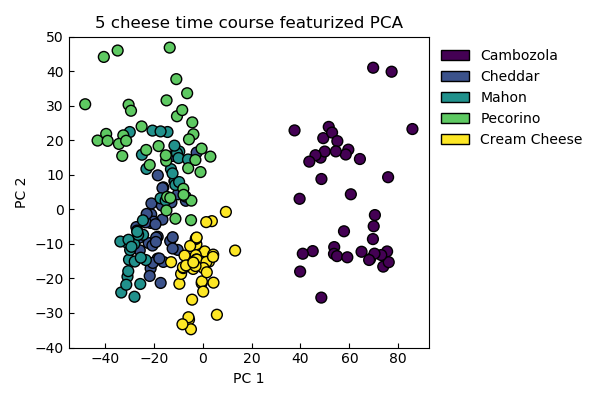

In [96]:
import matplotlib.patches as mpatches

labels = np.array([[0,1,2,3,4]])
labels = np.repeat(labels, 40, axis=1).flatten()

ss = StandardScaler()
pca = PCA(n_components=10)
X = ss.fit_transform(extracted_feat)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:,0], X_pca[:,1], s=60, alpha=1, c=labels, cmap='viridis', edgecolor='k')
ax = plt.gca()
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
ax.set_ylim([-40,50])
ax.set_ylabel('PC 2')
ax.set_xlabel('PC 1')
plt.title('5 cheese time course featurized PCA')
cmap = plt.cm.get_cmap('viridis')
hands = []
for i,label in zip([0,0.25,.5,0.75,1.0],['Cambozola','Cheddar','Mahon','Pecorino','Cream Cheese']):
    rgba = cmap(i)
    p1 = mpatches.Patch(edgecolor='k', facecolor=rgba, label=label, alpha=1)
    hands.append(p1)
plt.legend(handles=hands, bbox_to_anchor=(1, 1), frameon=False)
plt.tight_layout()
plt.savefig('./cheese_5_selectors_4/PCA_all_5_cheeses.png')
# plt.show()

In [90]:
# from tsfresh import extract_features
# from tsfresh import select_features
# from tsfresh.utilities.dataframe_functions import impute
# import itertools


# # getting the data into a format for the extract_features....
# start = 300
# end = 600
# length=end-start
# selectors = [4,5,6,20]
# combined = []
# for select in selectors:
#     selector = []
#     for w in sorted(data.keys()):
#         selector_data = data[w]['S'+str(select)]
#         selector_data = selector_data.T.fillna(selector_data.mean(axis=1)).T 
#         selector.append(selector_data)
#     selector = pd.concat(selector, axis=1)
#     selector = selector.values.T
#     selector = selector[:, start:end].reshape(-1,1)
#     print(selector[:5])
#     combined.append(selector)
# combined = np.concatenate(combined, axis=1)
# time = np.asarray([i for i in range(end-start)]*156).reshape(-1,1) # 4 (replicates in a TC) * 13 repeats *3 cheese = 36
# combined = np.append(combined,time, axis=1)
# combined_df = pd.DataFrame(combined, columns=['S4','S5', 'S6', 'S20', 'time'])
# name_c = ['C1_{}'.format(i) for i in range(1,53)]
# name_c = [[ele]*length for ele in name_c]
# name_c = [j for i in name_c for j in i]
# name_m = ['M1_{}'.format(i) for i in range(1,53)]
# name_m = [[ele]*length for ele in name_m]
# name_m = [j for i in name_m for j in i]
# name_p = ['P1_{}'.format(i) for i in range(1,53)]
# name_p = [[ele]*length for ele in name_p]
# name_p = [j for i in name_p for j in i]
# names = name_c + name_m + name_p
# combined_df['id'] = names

# extracted_feat = extract_features(combined_df, column_id="id", column_sort="time", column_kind=None, column_value=None)
# impute(extracted_feat)

[[-0.06163056]
 [-0.11910121]
 [-0.4683998 ]
 [-0.39448321]
 [-0.50543414]]
[[-0.06479585]
 [-0.108186  ]
 [-0.11387668]
 [-0.1572667 ]
 [-0.23835619]]
[[-0.04253916]
 [-0.05911626]
 [-0.09907726]
 [-0.12734636]
 [-0.155615  ]]
[[-0.015329  ]
 [-0.01598015]
 [-0.21344543]
 [-0.21409659]
 [-0.41156187]]


Feature Extraction: 100%|██████████| 20/20 [02:23<00:00,  3.95s/it]


In [109]:
# to play around with taking just select selectors for the RF in the next cell
column_names = list(extracted_feat)
new_names = []
for col in column_names:
    if 'S5' in col or 'S6' in col or 'S20' in col:
        new_names.append(col)
minextracted = extracted_feat[new_names]
minextracted
print(minextracted.shape)

(200, 2382)


In [113]:
classifier = 'RF'
labels = np.array([[0,1,2,3,4]])
labels = np.repeat(labels, 40, axis=1).flatten()
# features_filtered = select_features(extracted_feat, labels)
# features_filtered.shape


# this 794 is from the number of features each of the selectors has in the new df...might need to change
# you can get it from the commented out code at the end of this cell...'note see above....' this chunk

accuracies = []
for j in range(100):
    data_combined_sh, labels_sh = shuffle(extracted_feat.values, labels)
    x_train, x_test, y_train, y_test = train_test_split(data_combined_sh, labels_sh, test_size=0.15)
    x_train_list = np.split(x_train,4, axis=1)
    x_test_list = np.split(x_test,4, axis=1)
    pred_test_combined = []
    for x_tr, x_ts in zip(x_train_list,x_test_list):
        clf = get_classifier(classifier)
        clf.fit(x_tr, y_train)
        pred_test_combined.append(clf.predict(x_ts))
    pred_test_combined = np.concatenate(pred_test_combined)
    pred_test_combined = pred_test_combined.reshape((-1,y_test.shape[0]))
    combined_vote = []
    for i in range(y_test.shape[0]):
        unique, counts = np.unique(pred_test_combined[:,i], return_counts=True)
        counts = dict(zip(unique, counts))
        majority = get_majority_vote(counts)
        combined_vote.append(majority)
    combined_vote = np.asarray(combined_vote)
    accuracies.append(accuracy_score(y_test, combined_vote))
accuracies = np.asarray(accuracies)
print(accuracies)
print('the accuracy is ', accuracies.mean(), '+/-', accuracies.std())

[0.96666667 0.93333333 0.93333333 0.86666667 1.         1.
 0.96666667 1.         0.9        1.         1.         0.83333333
 0.86666667 0.9        0.93333333 0.96666667 0.93333333 0.96666667
 0.96666667 0.96666667 0.93333333 0.96666667 0.9        0.9
 0.96666667 0.96666667 0.96666667 0.9        0.96666667 0.93333333
 0.93333333 0.9        0.9        0.83333333 0.93333333 0.96666667
 0.9        0.93333333 0.96666667 1.         0.96666667 0.96666667
 0.96666667 0.93333333 0.86666667 0.96666667 0.96666667 0.93333333
 0.9        1.         0.96666667 1.         0.96666667 0.93333333
 0.9        1.         1.         0.93333333 0.93333333 0.96666667
 0.96666667 0.86666667 0.96666667 0.96666667 0.93333333 0.96666667
 0.86666667 0.86666667 0.96666667 0.96666667 0.93333333 0.93333333
 0.86666667 1.         0.93333333 0.93333333 0.9        0.93333333
 0.96666667 0.93333333 0.9        0.93333333 0.9        0.96666667
 0.96666667 0.96666667 0.9        0.96666667 0.93333333 0.86666667
 1.       

In [121]:
# relaxing condition for the blocks to go together
start = 300
end = 600
classifier = 'KNN'
selectors = [4,5,6,20]
data_combined = []
accuracies = []

for i in selectors:
    selector = []
    for w in sorted(data.keys()):
        if w[0] in ['c', 'm', 'p']:
            if w[1:] in ['01', '02', '03']:
                continue
        elif int(w[1:]) > 10:
            continue
        selector_data = data[w]['S'+str(i)]
        selector_data = selector_data.T.fillna(selector_data.mean(axis=1)).T 
        selector.append(selector_data)
    selector = pd.concat(selector, axis=1)
    selector = selector.values.T
    selector = selector[:, start:end]
    data_combined.append(selector)
data_combined = np.concatenate(data_combined, axis=1)
labels = np.array([[0,1,2,3,4]])
labels = np.repeat(labels, 40, axis=1).flatten()

for j in range(50):
    data_combined_sh, labels_sh = shuffle(data_combined, labels)
    x_train, x_test, y_train, y_test = train_test_split(data_combined_sh, labels_sh, test_size=0.15)
    x_train_list = np.split(x_train,len(selectors), axis=1)
    x_test_list = np.split(x_test,len(selectors), axis=1)

    pred_test_combined = []
    for x_tr, x_ts in zip(x_train_list,x_test_list):
        clf = get_classifier(classifier)
        clf.fit(x_tr, y_train)
        pred_test_combined.append(clf.predict(x_ts))
    pred_test_combined = np.concatenate(pred_test_combined)
    pred_test_combined = pred_test_combined.reshape((-1,y_test.shape[0]))
    combined_vote = []
    for i in range(y_test.shape[0]):
        unique, counts = np.unique(pred_test_combined[:,i], return_counts=True)
        counts = dict(zip(unique, counts))
        majority = get_majority_vote(counts)
        combined_vote.append(majority)
    combined_vote = np.asarray(combined_vote)
    accuracies.append(accuracy_score(y_test, combined_vote))
accuracies = np.asarray(accuracies)
print(accuracies)
print('the accuracy is ', accuracies.mean(), '+/-', accuracies.std())



[0.93333333 0.8        0.86666667 0.8        0.8        0.76666667
 0.76666667 0.8        0.8        0.86666667 0.8        0.66666667
 0.83333333 0.7        0.76666667 0.8        0.76666667 0.86666667
 0.73333333 0.83333333 0.76666667 0.76666667 0.9        0.86666667
 0.76666667 0.83333333 0.8        0.8        0.8        0.86666667
 0.66666667 0.8        0.9        0.8        0.73333333 0.86666667
 0.83333333 0.83333333 0.73333333 0.83333333 0.7        0.73333333
 0.8        0.73333333 0.83333333 0.83333333 0.76666667 0.83333333
 0.8        0.8       ]
the accuracy is  0.7993333333333332 +/- 0.056760706283288796


In [128]:
start = 300
end = 600
classifier = 'KNN'

#labels:
labels = np.array([[0,1,2,3,4]])
labels = np.repeat(labels, 40, axis=1).flatten()

range_list = list(range(labels.shape[0]))
blocks = [range_list[i:i+4] for i in range(0,labels.shape[0], 4)]

accuracies = []
for i in range(1):
    #getting indicies of the blocks to use for the test set. 
    cheese_blocks = [[ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                     [10,11,12,13,14,15,16,17,18,19],
                     [20,21,22,23,24,25,26,27,28,29],
                     [30,31,32,33,34,35,36,37,38,39],
                     [40,41,42,43,44,45,46,47,48,49]]
    selector_masking_list = []
    for block in cheese_blocks:
        ## choosing two from each cheese to be in the test set..
        test_blocks = list(np.random.choice(block, size=2, replace=False))
        selector_masking_list += test_blocks
    ### use the values in the selector list to index the blocks list
    # block_combos = list(itertools.product(*cheese_blocks))  

    selector_drop_list = [[4,6,20]]
    for selector_list in selector_drop_list:
        pred_test_combined = []
        for i in selector_list:
            selector = []
            for w in sorted(data.keys()):
                if w[0] in ['c', 'm', 'p']:
                    if w[1:] in ['01', '02', '03']:
                        continue
                elif int(w[1:]) > 10:
                    continue
                selector_data = data[w]['S'+str(i)]
                selector_data = selector_data.T.fillna(selector_data.mean(axis=1)).T 
                selector.append(selector_data)
            selector = pd.concat(selector, axis=1)
#             selector['id'] = [1 for i in range(selector.shape[0])]
#             features = extract_features(selector, column_id='id')
            selector = selector.values.T
            selector = selector[:, start:end]
            selector = normalize_selector(selector)
            ##### MAKE SURE TO CHANGE THE NEXT LINE DEPENDING ON NUMBER CLASSES
            mask_test = []
            for ele in selector_masking_list:
                mask_test += blocks[ele]
#             print(mask_test)
            mask_train = [i for i in range(labels.shape[0]) if i not in mask_test]
#             print(mask_train)
            x_test = selector[mask_test,:]
            x_train = selector[mask_train,:]
            y_test = labels[mask_test]
            y_train = labels[mask_train]
            print(x_test[:10,:10])
#             clf = get_classifier(classifier)
#             x_train, y_train = shuffle(x_train, y_train)
#             clf.fit(x_train, y_train)
#             pred_test_combined.append(clf.predict(x_test)) # might be better to work with probablilites... predict_proba
#         pred_test_combined = np.concatenate(pred_test_combined)
#         pred_test_combined = pred_test_combined.reshape((-1,y_test.shape[0]))
#         combined_vote = []
#         for i in range(y_test.shape[0]):
#             unique, counts = np.unique(pred_test_combined[:,i], return_counts=True)
#             counts = dict(zip(unique, counts))
#             majority = get_majority_vote(counts)
#             combined_vote.append(majority)
#         combined_vote = np.asarray(combined_vote)
#         accuracies.append(accuracy_score(y_test, combined_vote))
# accuracies = np.asarray(accuracies)
# print(accuracies)
# print('the accuracy is ', accuracies.mean(), '+/-', accuracies.std())



[[0.33832436 0.33832423 0.33420031 0.33420019 0.33420006 0.33007614
  0.33007601 0.33007589 0.33007576 0.33007564]
 [0.33973645 0.33527072 0.33519681 0.33073108 0.33065717 0.33058326
  0.33050936 0.33043545 0.33036154 0.33028763]
 [0.33739346 0.33565699 0.33235564 0.33061917 0.33044758 0.33027599
  0.32853952 0.32836793 0.32663147 0.32645988]
 [0.33646813 0.33475629 0.33304445 0.33133261 0.33121736 0.32950552
  0.32939026 0.32927501 0.32915975 0.3290445 ]
 [0.34331515 0.34217241 0.34102965 0.34115246 0.34127527 0.34139808
  0.34025532 0.34037813 0.33054228 0.3355615 ]
 [0.34352973 0.34170839 0.3411797  0.34129732 0.34141494 0.34153256
  0.34100387 0.34047518 0.33248338 0.3368325 ]
 [0.34411227 0.34176187 0.34106685 0.34119952 0.34133218 0.34146485
  0.34159752 0.34007481 0.33239919 0.33620171]
 [0.34387063 0.34087532 0.34097908 0.34108284 0.3411866  0.34129036
  0.34139412 0.33994834 0.33076868 0.33550725]
 [0.33055671 0.31982796 0.31000142 0.2938867  0.27777198 0.2554511
  0.25091484 

In [124]:
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import squareform

def indiv_sel_avg_all_to_all_dist(sel_mat, classes):
    sample_num = sel_mat.shape[0]
    class_mat_list = np.split(sel_mat, classes, axis=0)
    all_dists = []
    seen = []
    for int_1, class_mat_1 in enumerate(class_mat_list):
        for int_2, class_mat_2 in enumerate(class_mat_list):
            if int_1 == int_2:
                continue
            if (int_1,int_2) in seen or (int_2,int_1) in seen:
                continue
            seen.append((int_1, int_2))
            distances = euclidean_distances(class_mat_1, class_mat_2)
            mean = distances.mean()
            all_dists.append(mean)
    all_distances = np.asarray(all_dists)
    return all_distances.sum()

def internal_class_dissim(sel_mat, classes):
    sample_num = sel_mat.shape[0]
    class_mat_list = np.split(sel_mat, classes, axis=0)
    class_distances = []
    for class_mat in class_mat_list:
        distances = euclidean_distances(class_mat, class_mat)
        distances = distances.round(5)
        linear_mat = squareform(distances)
        class_distances.append((linear_mat.mean(), linear_mat.std()))
    return class_distances
        
        
def avg_all_to_all_dist(m1, m2):
    distances = []
    for i in range(m1.shape[0]):
        for j in range(m2.shape[0]):
            distances.append(euclidean(m1[i,:], m2[j,:]))
    distances = np.asarray(distances)
    distance_mean = distances.mean()
    return distance_mean

def dist_water_and_ethanol(selector1, selector2):
    '''
    currently hardcoded for the water-ethanol datasets assuming sorted input! ie ethanol first, then water
    '''
    ethanol_dist = avg_all_to_all_dist(selector1[:12,:], selector2[:12,:])
    water_dist = avg_all_to_all_dist(selector1[12:,:], selector2[12:,:])
    return water_dist, ethanol_dist

def normalize_selector(sel_data):
    max_val = sel_data.max()
    min_val = sel_data.min()
    max_min = max_val - min_val
    sel_data = (sel_data - min_val) / float(max_min)
    return sel_data

[31.499426922194488, 23.95865204313783, 31.13466469077824, 30.873007114318533]
[8.569530038461538, 6.093675448717949, 8.300252987179487, 6.550935730769231]


<IPython.core.display.Javascript object>


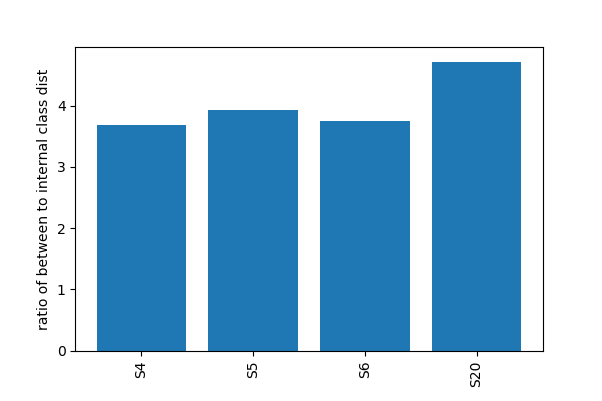

In [126]:
# calculating the dissimilarity of examples of class for each selector. 
start = 300
end = 600
classes = 5

def sel_summary(data_list): return sum([ele[0] for ele in data_list])

def data_summary(data_list):
    data_summary = []
    for d_list in data_list:
        data_summary.append(sel_summary(d_list))
    return data_summary

internal_class = []
between_class = []
labels = []
for i in [4,5,6,20]:
    labels.append('S'+str(i))
    selector = []
    for w in sorted(data.keys()):
        if w[0] in ['c', 'm', 'p']:
            if w[1:] in ['01', '02', '03']:
                continue
        elif int(w[1:]) > 10:
            continue
        selector_data = data[w]['S'+str(i)]
        selector_data = selector_data.T.fillna(selector_data.mean(axis=1)).T 
        selector.append(selector_data)
    selector = pd.concat(selector, axis=1)
    selector = selector.values.T
    selector = selector[:, start:end]
    selector = normalize_selector(selector)
    # the selector matrix is a Nxdelta_t matrix"
    # where the first half is of cheese 1 (or ethanol) and the 2nd is cheese 2 (or water)
    # OR 
    # if multiple cheeses its evenly split into three groups 
    between_class.append(indiv_sel_avg_all_to_all_dist(selector, classes))  
    internal_class.append(internal_class_dissim(selector, classes))
print(between_class)
internal_class = data_summary(internal_class)
print(internal_class)
ratio = np.divide(between_class,internal_class)
# print(summary, between_class)
ind = range(ratio.shape[0])
fig, ax = plt.subplots()
ax.set_xticks(ind)
# ax.set_ylim([1,])
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel('ratio of between to internal class dist')
plt.bar(ind,ratio)
plt.show()

#     sel_mean, sel_std = indiv_sel_avg_all_to_all_dist(selector)
#     all_data.append(('selector_{}'.format(i), sel_mean, sel_std))

(156, 300)


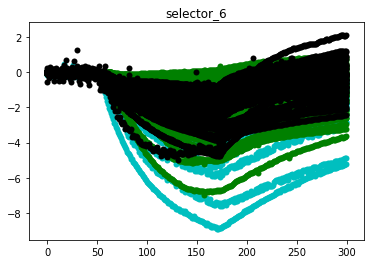

In [41]:
# just looking at selector 4:
start = 250
end = 600
select = 6
selector = []
for w in sorted(data.keys()):
    selector_data = data[w]['S'+str(select)]
    selector_data = selector_data.T.fillna(selector_data.mean(axis=1)).T 
    selector.append(selector_data)
selector = pd.concat(selector, axis=1)
selector = selector.values.T
selector = selector[:, start:end]
# selector = normalize_selector(selector)
print(selector.shape)


colors = ['c']*52 + ['g']*52 + ['k']*52
for j,c in enumerate(colors):
    y = selector[j,:]
    x = list(range(selector.shape[1]))
    plt.scatter(x,y,c=c, linewidth=0)
plt.title('selector_6')
plt.show()
